In [134]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import pandas as pd
from sklearn.metrics import r2_score
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import lasso_path
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

This MALDI-TOF dataset consists in: A) A reference panel of 20 Gram positive and negative bacterial species covering 9 genera among which several species are known to be hard to discriminate by mass spectrometry (MALDI-TOF). Each species was represented by 11 to 60 mass spectra obtained from 7 to 20 bacterial strains, constituting altogether a dataset of 571 spectra obtained from 213 strains. The spectra were obtained according to the standard culture-based workflow used in clinical routine in which the microorganism was first grown on an agar plate for 24 to 48 hours, before a portion of colony was picked, spotted on a MALDI slide and a mass spectrum was acquired.

Questions to address:

Can you count something interesting? No

Can you find trends (e.g. high, low, increasing, decreasing, anomalies)? There is no apparent trend among the samples

Can you make a bar plot or a histogram?  It does not seem appropriate to make a bar plot or histogram

Can you compare two related quantities?  We can compare the pure spectra with the mixed spectra

Can you make a scatterplot?  A line graph is better than a scatter plot in this case

Can you make a time-series plot?  The data is not a function of time

<h2>Use Lasso Regression to Predict Bacterial Strains in Samples</h2>

<h3>Input Pure Spectra</h3>

In [135]:
df_pure_spectra_matrix = pd.read_csv('pure_spectra_matrix.csv', delimiter=';')
print(df_pure_spectra_matrix.head(10))
print(len(df_pure_spectra_matrix))

   0  0.1  0.2  0.3  0.4  0.5  44431.921875  0.6  0.7  0.8   ...    \
0  0    0  0.0  0.0  0.0    0      0.000000  0.0  0.0  0.0   ...     
1  0    0  0.0  0.0  0.0    0      0.000000  0.0  0.0  0.0   ...     
2  0    0  0.0  0.0  0.0    0      0.000000  0.0  0.0  0.0   ...     
3  0    0  0.0  0.0  0.0    0   4701.712402  0.0  0.0  0.0   ...     
4  0    0  0.0  0.0  0.0    0      0.000000  0.0  0.0  0.0   ...     
5  0    0  0.0  0.0  0.0    0      0.000000  0.0  0.0  0.0   ...     
6  0    0  0.0  0.0  0.0    0      0.000000  0.0  0.0  0.0   ...     
7  0    0  0.0  0.0  0.0    0      0.000000  0.0  0.0  0.0   ...     
8  0    0  0.0  0.0  0.0    0      0.000000  0.0  0.0  0.0   ...     
9  0    0  0.0  0.0  0.0    0      0.000000  0.0  0.0  0.0   ...     

         0.1217  0.1218  0.1219         0.1220        0.1221  0.1222  0.1223  \
0  27667.777344     0.0       0       0.000000  35438.351562     0.0     0.0   
1  59820.968750     0.0       0       0.000000   6384.590820     0.0 

Transpose the dataframe to make compatible with plot.line()

In [136]:
df_pure_spectra_matrix_transposed = df_pure_spectra_matrix.T

Plot three representative spectra of bacteria from pure samples

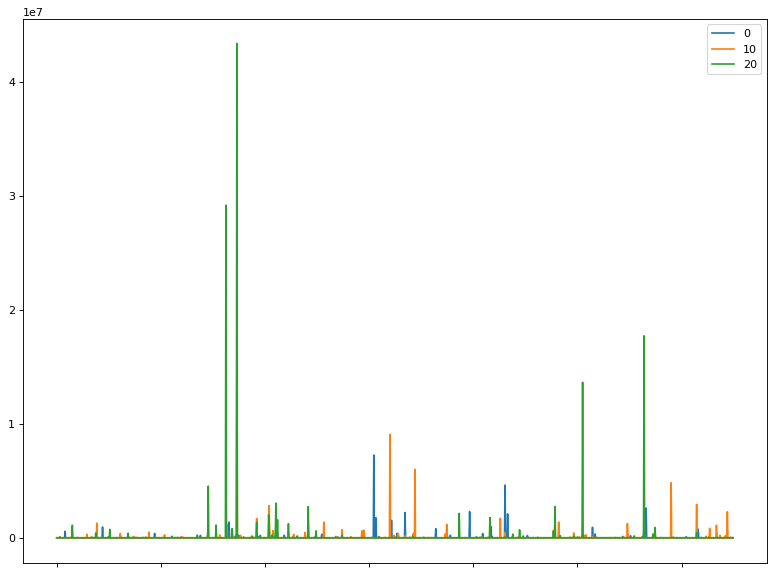

In [137]:
figure(num=None, figsize=(12, 9), dpi=80, facecolor='w', edgecolor='k')

df_pure_spectra_matrix_transposed[0].plot.line(legend=True)
df_pure_spectra_matrix_transposed[10].plot.line(legend=True)
df_pure_spectra_matrix_transposed[20].plot.line(legend=True)

<h3>Check Pure Spectra Metadata</h3>

In [138]:
df_pure_spectra_metadata = pd.read_csv('pure_spectra_metadata.csv', delimiter=';')
print(df_pure_spectra_metadata.head(571))
print(len(df_pure_spectra_metadata))

     Species  Strain
0    RTO.TQH       1
1    BUT.YZE       2
2    BUT.YZE       2
3    BUT.YZE       2
4    BUT.YZE       2
5    VVJ.KSF       3
6    VVJ.KSF       3
7    VVJ.KSF       3
8    VVJ.KSF       3
9    VVJ.KSF       4
10   VVJ.KSF       4
11   VVJ.KSF       5
12   VVJ.KSF       5
13   VVJ.KSF       5
14   VVJ.KSF       6
15   VVJ.KSF       6
16   VVJ.KSF       7
17   VVJ.KSF       7
18   VVJ.KSF       7
19   VVJ.KSF       7
20   VVJ.KSF       7
21   VVJ.KSF       7
22   BUT.YZE       8
23   BUT.YZE       8
24   JNH.FLH       9
25   JNH.FLH       9
26   BUT.DNW      10
27   BUT.DNW      10
28   BUT.BIK      11
29   BUT.BIK      12
..       ...     ...
541  NYV.VCE     202
542  NYV.VCE     202
543  NYV.VCE     202
544  RTO.JFR     203
545  RTO.JFR     203
546  QWP.LRO     204
547  QWP.LRO     205
548  JNH.FLH     206
549  JNH.FLH     206
550  JNH.FLH     206
551  JNH.FLH     206
552  QWP.DRH     207
553  QWP.DRH     207
554  JNH.FLH     208
555  JNH.FLH     208
556  JNH.ZIJ 

In [139]:
df_pure_spectra_metadata["Strain"].value_counts(ascending=True)
df_pure_spectra_metadata.loc[df_pure_spectra_metadata["Strain"] == 214]

,Species,Strain


<h3>Input Mixed Spectra Metadata and Check</h3>

In [140]:
df_mixed_spectra_metadata = pd.read_csv('mixed_spectra_metadata.csv', delimiter=';')
print(df_mixed_spectra_metadata)
print(len(df_mixed_spectra_metadata))

    Mixture_Label  Mixture_Id Species_1  Strain_1 Species_2  Strain_2  \
0               A           1   NYV.XSY       214   NYV.VCE        77   
1               A           1   NYV.XSY       214   NYV.VCE        77   
2               A           1   NYV.XSY       214   NYV.VCE        77   
3               A           1   NYV.XSY       214   NYV.VCE        77   
4               A           1   NYV.XSY       214   NYV.VCE        77   
5               A           1   NYV.XSY       214   NYV.VCE        77   
6               A           1   NYV.XSY       214   NYV.VCE        77   
7               A           1   NYV.XSY       214   NYV.VCE        77   
8               A           1   NYV.XSY       214   NYV.VCE        77   
9               A           1   NYV.XSY       214   NYV.VCE        77   
10              A           1   NYV.XSY       214   NYV.VCE        77   
11              A           1   NYV.XSY       214   NYV.VCE        77   
12              A           1   NYV.XSY       214  

B) Based on this reference panel, a dedicated in vitro mock-up mixture dataset was constituted. For that purpose we considered 10 pairs of species of various taxonomic proximity:
* 4 mixtures, labelled A, B, C and D, involved species that belong to the same genus,
* 2 mixtures, labelled E and F, involved species that belong to distinct genera, but to the same Gram type,
* 4 mixtures, labelled G, H, I and J, involved species that belong to distinct Gram types.
Each mixture was represented by 2 pairs of strains, which were mixed according to the following 9 concentration ratios : 1:0, 10:1, 5:1, 2:1, 1:1, 1:2, 1:5, 1:10, 0:1. Two replicate spectra were acquired for each concentration ratio and each couple of strains, leading altogether to a dataset of 360 spectra, among which 80 are actually pure sample spectra.

<h3>Input Mixed Spectra and Check</h3>

In [141]:
df_mixed_spectra_matrix = pd.read_csv('mixed_spectra_matrix.csv', delimiter=';', header=None)
print(df_mixed_spectra_matrix.head(360))

print("Number of mixed spectra (80 are actually pure sample spectra):")
print(len(df_mixed_spectra_matrix))

     0     1           2     3     4     5     6             7     \
0       0   0.0        0.00   0.0   0.0     0   0.0      0.000000   
1       0   0.0        0.00   0.0   0.0     0   0.0      0.000000   
2       0   0.0        0.00   0.0   0.0     0   0.0      0.000000   
3       0   0.0        0.00   0.0   0.0     0   0.0      0.000000   
4       0   0.0        0.00   0.0   0.0     0   0.0      0.000000   
5       0   0.0        0.00   0.0   0.0     0   0.0      0.000000   
6       0   0.0        0.00   0.0   0.0     0   0.0      0.000000   
7       0   0.0        0.00   0.0   0.0     0   0.0      0.000000   
8       0   0.0        0.00   0.0   0.0     0   0.0      0.000000   
9       0   0.0        0.00   0.0   0.0     0   0.0      0.000000   
10      0   0.0        0.00   0.0   0.0     0   0.0      0.000000   
11      0   0.0        0.00   0.0   0.0     0   0.0      0.000000   
12      0   0.0        0.00   0.0   0.0     0   0.0      0.000000   
13      0   0.0        0.00   0.0 

In [142]:
df_mixed_spectra_matrix_transposed = df_mixed_spectra_matrix.T

Plot three representative spectra of bacteria from mixed samples

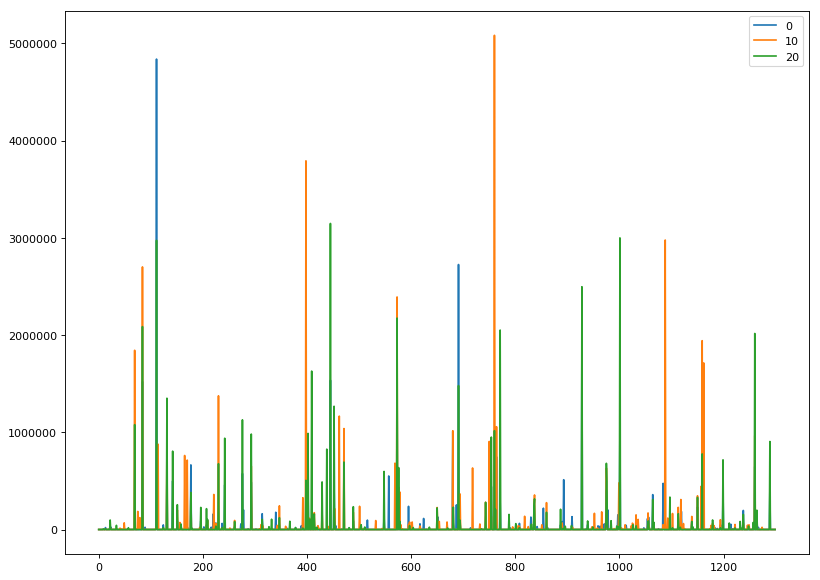

In [143]:
figure(num=None, figsize=(12, 9), dpi=80, facecolor='w', edgecolor='k')

df_mixed_spectra_matrix_transposed[0].plot.line(legend=True)
df_mixed_spectra_matrix_transposed[10].plot.line(legend=True)
df_mixed_spectra_matrix_transposed[20].plot.line(legend=True)

<h3>Input Mixed Spectra Metadata</h3>

In [144]:
df_mixed_spectra_metadata = pd.read_csv('mixed_spectra_metadata.csv', delimiter=';')
print(df_mixed_spectra_metadata.head(20))
print("Number of mixed spectra (80 are actually pure sample spectra):")
print(len(df_mixed_spectra_metadata))
#Notice that the ratio indicates whether a strain is present or not

   Mixture_Label  Mixture_Id Species_1  Strain_1 Species_2  Strain_2  \
0              A           1   NYV.XSY       214   NYV.VCE        77   
1              A           1   NYV.XSY       214   NYV.VCE        77   
2              A           1   NYV.XSY       214   NYV.VCE        77   
3              A           1   NYV.XSY       214   NYV.VCE        77   
4              A           1   NYV.XSY       214   NYV.VCE        77   
5              A           1   NYV.XSY       214   NYV.VCE        77   
6              A           1   NYV.XSY       214   NYV.VCE        77   
7              A           1   NYV.XSY       214   NYV.VCE        77   
8              A           1   NYV.XSY       214   NYV.VCE        77   
9              A           1   NYV.XSY       214   NYV.VCE        77   
10             A           1   NYV.XSY       214   NYV.VCE        77   
11             A           1   NYV.XSY       214   NYV.VCE        77   
12             A           1   NYV.XSY       214   NYV.VCE      

<h2>Example of mixed spectra with pure spectra</h2>

*Looking at the plots, what are some insights you can make?*

Some of the data from pure spectra overlap

*Do you see any correlations?*

There does not appear to be as much overlap as expected for the pure spectra with the respective mixed spectra

*Is there a hypothesis you’d like to investigate further? What other questions do the insights lead you to ask?*

I would like to investigate this further (whether there are small signals that overlap) especially if the results do not meet expectations.

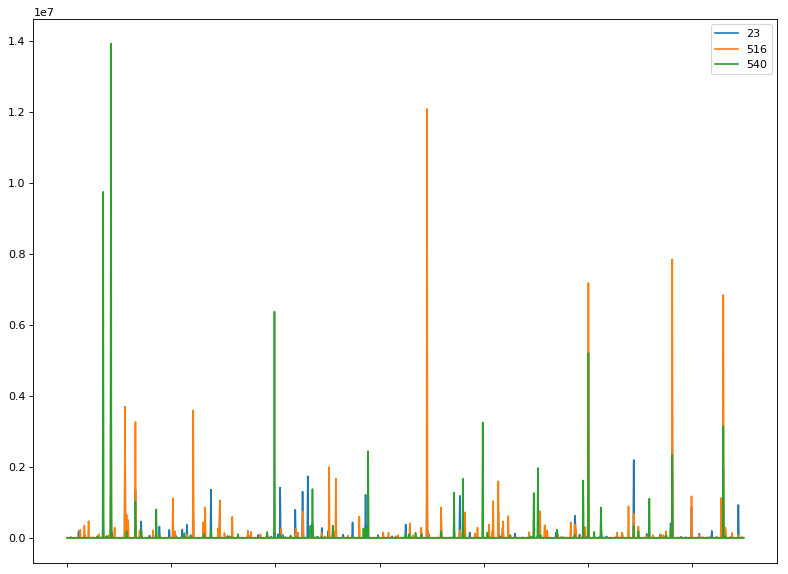

In [145]:
figure(num=None, figsize=(12, 9), dpi=80, facecolor='w', edgecolor='k')

df_mixed_spectra_matrix_transposed[23].plot.line(legend=True)
df_pure_spectra_matrix_transposed[516].plot.line(legend=True) #516 is sample 194
df_pure_spectra_matrix_transposed[540].plot.line(legend=True) #540 is sample 202

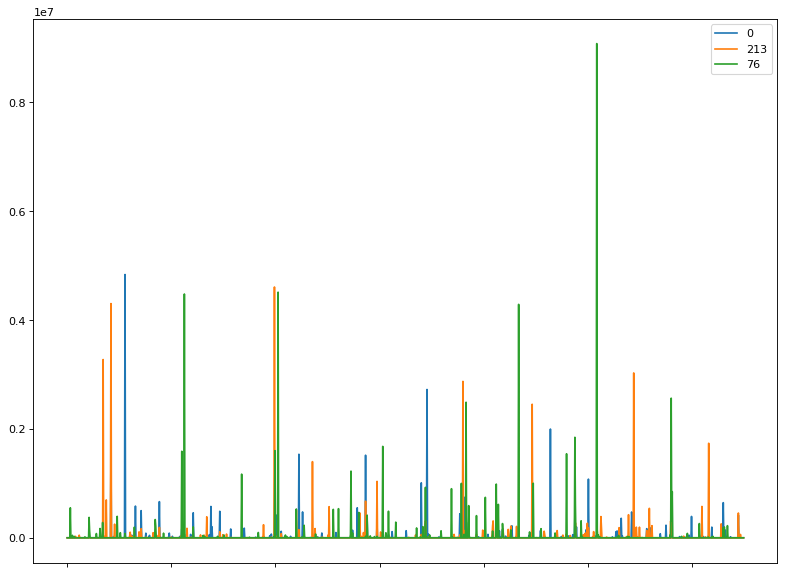

In [146]:
figure(num=None, figsize=(12, 9), dpi=80, facecolor='w', edgecolor='k')

df_mixed_spectra_matrix_transposed[0].plot.line(legend=True)
df_pure_spectra_matrix_transposed[213].plot.line(legend=True)
df_pure_spectra_matrix_transposed[76].plot.line(legend=True)

<h3>One-hot encode y_train</h3>

In [147]:
X_train = df_pure_spectra_matrix
print("Shape of X_train")
print(X_train.shape)
y_train = df_pure_spectra_metadata["Strain"][0:570]
X_test = df_mixed_spectra_matrix

enc = OneHotEncoder(sparse=False)

#columns : list, optional, default:None. If None, return all columns, otherwise, returns specified columns
y_train_reshape = y_train.as_matrix(columns=None)
y_train_reshape = y_train_reshape.reshape(-1, 1)
Y_transform = enc.fit_transform(y_train_reshape)

print("Transformed y_train to onehot encoding (Y_transform)")
print(Y_transform)
print("Shape of Y_transform")
print(Y_transform.shape)

Shape of X_train
(570, 1300)
Transformed y_train to onehot encoding (Y_transform)
[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]
Shape of Y_transform
(570, 213)


/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:10: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # Remove the CWD from sys.path while we load stuff.


<h3>Instantiate a Lasso regressor, fit the training data, and predict y_train</h3>

In [148]:
# Instantiate a lasso regressor: lassoreg
lassoreg = Lasso(normalize=True, positive=True, alpha = .0000005, max_iter=100)

# Fit the regressor to the data
lassoreg.fit(X_train,Y_transform)

## Compute the coefficients
#lassoreg_coef = lassoreg.coef_

#Predict strain from X_train: y_pred_train
y_pred_train = lassoreg.predict(X_train)
print("y_pred_train")
print(y_pred_train)

#Check that the sum of probabilities is 1
#This is checked because some of the probabilities are negative or greater than one
print("Sum of probabilities")
Y_transform.sum(axis=1)

y_pred_train
[[ 8.29739943e-01  4.42456601e-01  4.39944024e-02 ... -1.45208973e-03
  -2.16921933e-03  5.00439174e-07]
 [ 2.44588676e-01  5.10575273e-01  3.35782100e-02 ...  1.11195454e-03
   8.62310452e-03  5.00439174e-07]
 [ 5.64385625e-02  1.01363924e+00  9.20472686e-03 ...  2.83407790e-03
  -4.67901581e-04  5.00439174e-07]
 ...
 [-3.96220690e-04 -9.28947752e-04  2.38591688e-02 ...  3.48771933e-02
   3.53246911e-01  5.00439174e-07]
 [-6.68003038e-03 -2.97700751e-03 -5.01627115e-03 ... -2.35998241e-02
   2.43179262e-01  5.00439174e-07]
 [ 1.99930685e-02  4.20650646e-03  3.70477458e-02 ...  5.26268481e-02
   2.51352532e-01  9.99715250e-01]]
Sum of probabilities


array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

<h3>Predict bacteria strain from pure spectra using Lasso regression</h3>

In [149]:
print("Predicted bacteria strain from pure spectra using Lasso regression")
print(y_pred_train.argmax(axis=1) + 1)

print("Matches of strain predicted for training using Lasso Regression with one-hot encoding and actual for each sample:")
print(Y_transform.argmax(axis=1)+1)
comparison_train = np.equal(Y_transform.argmax(axis=1)+1,y_pred_train.argmax(axis=1)+1)
print(comparison_train)

#function to calculate accuracy of model's prediction
def accuracy(comparison):
    total_samples = len(comparison)
    print("Total number of samples " + str(total_samples))
    matches = np.sum(comparison)
    print("Total number of matches " + str(matches))
    print("Percentage correct " + str(float(matches)/float(total_samples)))

accuracy(comparison_train)

Predicted bacteria strain from pure spectra using Lasso regression
[  1   2   2   2  75   3   7   3   3   4   4   3   5   5   6   6   7  23
   7   7   7 200 200   9   9  54  10  10  11  12  12  12  13 144  14  14
  14  15  15  15 138  16  16  17  17 172  18  18 105  18  19  20  21 136
  35  21  21  22  22 151  23  23   2  58  24  58 210  25  25  26  26  26
  26  27  27  27  27  29  29  29  29  29  30  31  31 126  31  32  33  33
  34  34  35  35  35  35  36  36  37  38  38  39  39  40  40  41  41  41
  41  42  42  42  43  42  43  44  44  44 131  45  46  46  47  47  47  47
  48  48  49  49  49  49  49 156  50  51  51  51  51  51  52 175  52  53
  53  53  54  54  54  55  55  56  56  56  56  57 107  57 212  58  58  58
  54  59  58  59  60  61   4  62  62  62  63  63  63  63  64  64  66  66
  66  66  66  66  66  67 155 155  68  69  69  69  69  70  70  70  71  72
  72  72  73  73  74  74  74  74  74  74  76  76  76  76  77  77  77  77
  77  78  78  79  80  80  81  82  82  83  84  84  84  84 

In [150]:
print("Predict strain from X_test using Lasso Regression:")
y_pred_test = lassoreg.predict(X_test)

print("y_pred_test")
print(y_pred_test)

#print("The length of y_pred_test is: " + str(len(y_pred_test)))

print("The predicted strain in the mixture for each sample is:")
print(y_pred_test.argmax(axis=1)+1)
y_pred_test = y_pred_test.argmax(axis=1)+1

#print("The length of the mixed spectra metadata is: " + str(len(df_mixed_spectra_metadata)))
y_actual_first_strain = df_mixed_spectra_metadata['Strain_1']
#print((y_pred_test-1)==df_mixed_spectra_metadata['Strain_1'][1:] or (y_pred_test-1)==df_mixed_spectra_metadata['Strain_2'][1:])

#Compare the predicted strain with the actual first strain
comparison_one = np.equal(y_pred_test,y_actual_first_strain)
print(comparison_one)
accuracy(comparison_one)

#Store the second strain data
y_actual_second_strain = df_mixed_spectra_metadata['Strain_2']

#Compare the predicted strain with the actual second strain
comparison_two = np.equal(y_pred_test,y_actual_second_strain)
print(comparison_two)
accuracy(comparison_two)

Predict strain from X_test using Lasso Regression:
y_pred_test
[[-3.42327630e-03  1.70060955e-02 -1.40323013e-02 ...  9.31617738e-02
  -1.33732917e-02  5.00439174e-07]
 [-4.77277011e-03 -1.87388992e-03  2.25587718e-03 ...  2.47771954e-02
  -1.89781286e-02  5.00439174e-07]
 [-4.55062345e-03  1.02019770e-02 -1.72051342e-02 ...  4.92298529e-02
  -1.90498170e-02  5.00439174e-07]
 ...
 [-1.91746030e-03 -4.38414823e-03 -5.57884243e-03 ...  1.45573714e-02
  -1.38047532e-02  5.00439174e-07]
 [-6.03085857e-03 -5.17741186e-03 -7.93678771e-03 ...  2.50572359e-02
  -1.71454934e-02  5.00439174e-07]
 [ 1.25797402e-03 -2.70910081e-03  3.29571693e-03 ...  1.25813596e-02
  -1.35433951e-02  5.00439174e-07]]
The predicted strain in the mixture for each sample is:
[137 137 116 116 116 137 157 116  63  63  63  63  53  63 137  63  63  63
 157 157 180 180 180  69  15 157  63  15  63  63 150  63  53  63  63  53
  42 173  42 212  42  42  42  13  48 212  48  48  48  48  48  47 212  48
 122 144  55 144 144 122 1

In [151]:
#print("Predicted bacteria strain from pure spectra using Lasso regression")
#print(y_pred_train.argmax(axis=1) + 1)

#print(Y_transform_get_dummies.idxmax(axis=1)+1)

#comparison_train = np.equal(Y_transform_get_dummies.idxmax(axis=1)+1,y_pred_train.argmax(axis=1)+1)

#print("Bacteria strain from Y_transform matrix")
#print(Y_transform_get_dummies.idxmax(axis=1))
#print("Matches of strain predicted for training using Lasso Regression and actual for each sample:")
#comparison_train = np.equal(Y_transform_get_dummies.idxmax(axis=1),y_pred_train_get_dummies.argmax(axis=1) + 1)

#print(comparison_train)

#accuracy(comparison_train)

<h3>Get pandas to emit N-1 variables to avoid collinearity</h3>

In [152]:
#Y_transform_get_dummies = pd.get_dummies(y_train, drop_first=True, prefix='category', columns=['category'])

#One-hot encoding and remove one variable
Y_transform_get_dummies = pd.get_dummies(y_train, drop_first=True)
print(Y_transform_get_dummies)

     2    3    4    5    6    7    8    9    10   11  ...   204  205  206  \
0      0    0    0    0    0    0    0    0    0    0 ...     0    0    0   
1      1    0    0    0    0    0    0    0    0    0 ...     0    0    0   
2      1    0    0    0    0    0    0    0    0    0 ...     0    0    0   
3      1    0    0    0    0    0    0    0    0    0 ...     0    0    0   
4      1    0    0    0    0    0    0    0    0    0 ...     0    0    0   
5      0    1    0    0    0    0    0    0    0    0 ...     0    0    0   
6      0    1    0    0    0    0    0    0    0    0 ...     0    0    0   
7      0    1    0    0    0    0    0    0    0    0 ...     0    0    0   
8      0    1    0    0    0    0    0    0    0    0 ...     0    0    0   
9      0    0    1    0    0    0    0    0    0    0 ...     0    0    0   
10     0    0    1    0    0    0    0    0    0    0 ...     0    0    0   
11     0    0    0    1    0    0    0    0    0    0 ...     0    0    0   

<h3>Instantiate a lasso regressor and fit to data with N-1 variables</h3>

In [153]:
# Instantiate a lasso regressor: lassoreg
lassoreg = Lasso(normalize=True, positive=True, alpha = .00001, max_iter=100, selection="random")

# Fit the regressor to the data
lassoreg.fit(X_train,Y_transform_get_dummies)

## Compute the coefficients
#lassoreg_coef = lassoreg.coef_

#print(lassoreg_coef)
y_pred_train_get_dummies = lassoreg.predict(X_train)
print("Prediction based on model fitted with N - 1 variables (y_pred_train_get_dummies)")
print(y_pred_train_get_dummies)

Prediction based on model fitted with N - 1 variables (y_pred_train_get_dummies)
[[ 4.38708134e-01  4.61256541e-02  2.69077221e-03 ... -5.39521966e-03
  -2.33877406e-03 -1.43655871e-05]
 [ 5.05075852e-01  3.60602412e-02  3.75480978e-03 ... -2.47298412e-03
   9.51268080e-03 -1.43655871e-05]
 [ 1.00875040e+00  1.28318880e-02 -4.60481643e-03 ... -1.78388311e-03
  -4.79444427e-03 -8.21479094e-06]
 ...
 [ 5.73514491e-04  2.37774474e-02 -4.53620112e-03 ...  3.44534954e-02
   3.49021683e-01 -1.43655871e-05]
 [-3.58817941e-03 -2.37699930e-03 -4.74591856e-03 ... -1.96935722e-02
   2.35842221e-01 -1.12140350e-05]
 [ 2.27725858e-03  3.59226511e-02 -2.50733051e-04 ...  5.47186646e-02
   2.46271208e-01  9.94305002e-01]]


<h3>Display bacteria strain predicted from X_train, show matches with Y_transform, and calculate accuracy</h3>

In [154]:
print("One-hot encoded Y matrix with N - 1 variables")
print(Y_transform_get_dummies)
#print(Y_transform_get_dummies.idxmax(axis=1)+1)
#comparison_train = np.equal(Y_transform_get_dummies.idxmax(axis=1)+1,y_pred_train.argmax(axis=1)+1)
print("Bacteria strain from Y_transform matrix")
print(Y_transform_get_dummies.idxmax(axis=1)-1)
print("Matches of strain predicted for training using Lasso Regression and actual for each sample:")
comparison_train = np.equal(Y_transform_get_dummies.idxmax(axis=1)-1,y_pred_train_get_dummies.argmax(axis=1)+1)

print(comparison_train)

accuracy(comparison_train)

One-hot encoded Y matrix with N - 1 variables
     2    3    4    5    6    7    8    9    10   11  ...   204  205  206  \
0      0    0    0    0    0    0    0    0    0    0 ...     0    0    0   
1      1    0    0    0    0    0    0    0    0    0 ...     0    0    0   
2      1    0    0    0    0    0    0    0    0    0 ...     0    0    0   
3      1    0    0    0    0    0    0    0    0    0 ...     0    0    0   
4      1    0    0    0    0    0    0    0    0    0 ...     0    0    0   
5      0    1    0    0    0    0    0    0    0    0 ...     0    0    0   
6      0    1    0    0    0    0    0    0    0    0 ...     0    0    0   
7      0    1    0    0    0    0    0    0    0    0 ...     0    0    0   
8      0    1    0    0    0    0    0    0    0    0 ...     0    0    0   
9      0    0    1    0    0    0    0    0    0    0 ...     0    0    0   
10     0    0    1    0    0    0    0    0    0    0 ...     0    0    0   
11     0    0    0    1    0  

The above calculations show that using N-1 variables does not improve the accuracy

<h3>Predict strain from mixtures using X_test data for input</h3>

In [155]:
print("Predict strain from X_test using Lasso Regression:")
y_pred_test = lassoreg.predict(X_test)

print("y_pred_test")
print(y_pred_test)

#print("The length of y_pred_test is: " + str(len(y_pred_test)))

print("The predicted strain in the mixture for each sample is:")
print(y_pred_test.argmax(axis=1)+1)
y_pred_test = y_pred_test.argmax(axis=1)+1

#print("The length of the mixed spectra metadata is: " + str(len(df_mixed_spectra_metadata)))
y_actual_first_strain = df_mixed_spectra_metadata['Strain_1']
#print((y_pred_test-1)==df_mixed_spectra_metadata['Strain_1'][1:] or (y_pred_test-1)==df_mixed_spectra_metadata['Strain_2'][1:])

#Compare the predicted strain with the actual first strain
comparison_one = np.equal(y_pred_test,y_actual_first_strain)
print(comparison_one)
accuracy(comparison_one)

#Store the second strain data
y_actual_second_strain = df_mixed_spectra_metadata['Strain_2']

#Compare the predicted strain with the actual second strain
comparison_two = np.equal(y_pred_test,y_actual_second_strain)
print(comparison_two)
accuracy(comparison_two)

Predict strain from X_test using Lasso Regression:
y_pred_test
[[ 5.99771440e-03 -1.15836087e-02  2.11125992e-04 ...  9.56755456e-02
  -1.26912683e-02  3.80444031e-06]
 [-3.64438798e-03  3.90779611e-03 -3.58775547e-03 ...  2.76230064e-02
  -1.66932701e-02 -2.29393012e-06]
 [ 6.07368728e-03 -1.34264554e-02  1.06751375e-03 ...  5.20431477e-02
  -1.67980292e-02  2.77914399e-05]
 ...
 [-2.45087037e-03 -3.62308744e-03 -5.04839634e-03 ...  1.59006814e-02
  -1.16141799e-02 -1.43655871e-05]
 [-3.70066083e-03 -4.79511641e-03 -3.43739183e-03 ...  2.62365036e-02
  -1.38713726e-02  6.65706859e-06]
 [-2.12030613e-03  5.50391896e-03 -3.45954118e-03 ...  1.31690554e-02
  -1.13902502e-02  2.39087326e-05]]
The predicted strain in the mixture for each sample is:
[136 136 115 115 115 136 156 115  62  62  62  62  52  62 136  62  62  62
 156 156 179 179 179  68 156 156  62  14  62  62 149  62  52  62  62  52
  41 172  41 121  41  41  41  12  47 211  47  47  47  47  47  46 211  47
 121 143  54 143 143 121 1

<h2>Random forest classifier to predict strain</h2>

In [156]:
#clf=RandomForestClassifier(n_estimators=100, min_samples_split=2, min_samples_leaf=1)
#clf=RandomForestClassifier()
clf = RandomForestClassifier(n_estimators=1000, max_depth=1000, min_samples_split=2, min_impurity_decrease=1e-5, random_state=5, max_features="auto")

print("Shape of X_train:")
print(X_train.shape)
print("Shape of Y_transform:")
print(Y_transform_get_dummies.shape)

#Fit model using X_train and Y_transform
clf.fit(X_train,Y_transform_get_dummies)

#Predict based on X_train expecting result of Y_transform
y_pred_train_random_forest=clf.predict(X_train)
print("Prediction based on X_train and fitted model:")
print(y_pred_train_random_forest)

comparison_train = np.equal(Y_transform_get_dummies.idxmax(axis=1)-1,y_pred_train_random_forest.argmax(axis=1)+1)

print("Matches of actual training data and predicted data:")
print(comparison_train)
accuracy(comparison_train)

#Predict using the training sets y_pred_test=clf.predict(X_test)
print("Prediction based on X_test and fitted model")

y_pred_test=clf.predict(X_test)
print(y_pred_test)
print("Strain predicted with random forest")
print(y_pred_test.argmax(axis=1))

#print(df_mixed_spectra_metadata[1]==y_pred_train.argmax(axis=1))
print("Matches of predicted strain with actual sample strain_1:")
comparison = np.equal(df_mixed_spectra_metadata["Strain_1"][0:570] - 1, y_pred_test.argmax(axis=1))
print(comparison)
accuracy(comparison)

print("Matches of predicted strain with actual sample strain_2:")
comparison = np.equal(df_mixed_spectra_metadata["Strain_2"][0:570] - 1, y_pred_test.argmax(axis=1))
print(comparison)
accuracy(comparison)

#print((y_train-1)==y_pred_train.argmax(axis=1))

Shape of X_train:
(570, 1300)
Shape of Y_transform:
(570, 212)
Prediction based on X_train and fitted model:
[[0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]
Matches of actual training data and predicted data:
0      True
1      True
2      True
3      True
4      True
5      True
6      True
7      True
8      True
9      True
10     True
11     True
12     True
13     True
14     True
15     True
16     True
17     True
18     True
19     True
20     True
21     True
22     True
23     True
24     True
25     True
26     True
27     True
28     True
29     True
       ... 
540    True
541    True
542    True
543    True
544    True
545    True
546    True
547    True
548    True
549    True
550    True
551    True
552    True
553    True
554    True
555    True
556    True
557    True
558    True
559    True
560    True
561    True
562    True
563    True
564    True
565    True

<h2> Logistic Regression to Predict Strain</h2>

In [ ]:
X_train = df_pure_spectra_matrix
y_train = df_pure_spectra_metadata["Strain"][0:570]
X_test = df_mixed_spectra_matrix
y_train = y_train.astype('category')
y_true = df_mixed_spectra_metadata["Strain_1"][0:570] - 1

# Instantiate a logistic regressor: logreg
logreg = LogisticRegression(penalty='l2', solver="newton-cg", multi_class="multinomial", max_iter=500)

# Fit the regressor to the data
print(X_train.shape)
print(y_train.shape)
logreg.fit(X_train, y_train)
#logreg.fit(X_train,Y_transform)

#print(lassoreg_coef)
y_pred_train_log = logreg.predict_proba(X_train)
print(y_pred_train_log)
y_pred_train_log_strain = y_pred_train_log.argmax(axis=1) + 1
print(y_pred_train_log_strain)

y_pred_test_log = logreg.predict_proba(X_test)
print(y_pred_test_log)
y_pred_test_log_strain = y_pred_test_log.argmax(axis=1) + 1
print(y_pred_test_log_strain)

print(df_mixed_spectra_metadata[:])

y_prediction = y_pred_test.argmax(axis=1)

print(y_true == y_prediction)
print("The matching accuracy of predicted versus ground truth is:")
print(accuracy_score(y_true, y_prediction))

print("Matches of predicted strain with actual sample strain_1:")
comparison = np.equal(df_mixed_spectra_metadata["Strain_1"][0:570] - 1, y_pred_test_log.argmax(axis=1) + 1)
print(comparison)
accuracy(comparison)

print("Matches of predicted strain with actual sample strain_2:")
comparison = np.equal(df_mixed_spectra_metadata["Strain_2"][0:570] - 1, y_pred_test_log.argmax(axis=1) + 1)
print(comparison)
accuracy(comparison)

(570, 1300)
(570,)


<h1>Please disregard the code below</h1>

<h2>Logistical Regression to Predict Strain</h2>

In [ ]:
X_train = df_pure_spectra_matrix
y_train = df_pure_spectra_metadata["Strain"][0:570]
X_test = df_mixed_spectra_matrix
y_train = y_train.astype('category')

# Instantiate a log regressor: logreg
logreg = LogisticRegression(penalty='l1')

# Fit the regressor to the data
print(X_train.shape)
print(y_train.shape)
logreg.fit(X_train,y_train)

#print(lassoreg_coef)
print(y_train)
y_pred_train = logreg.predict_proba(X_train)
print(y_pred_train)
y_pred_test = logreg.predict_proba(X_test)
print(y_pred_test)
print(df_mixed_spectra_metadata[:])

y_true = df_mixed_spectra_metadata["Strain_1"][0:570] - 1
y_prediction = y_pred_test.argmax(axis=1)

print(y_true == y_prediction)
print("The matching accuracy of predicted versus ground truth is:")
print(accuracy_score(y_true, y_prediction))

In [ ]:
X_train = df_pure_spectra_matrix
y_train = df_pure_spectra_metadata["Strain"][0:570]
X_test = df_mixed_spectra_matrix

print(y_train)

# Instantiate a lasso regressor: lassoreg
lassoreg = Lasso(normalize=True, positive=True, alpha = .1)

# Fit the regressor to the data
lassoreg.fit(X_train,y_train)

# Compute the coefficients
lassoreg_coef = lassoreg.coef_
#print(lassoreg_coef)
y_pred_train = lassoreg.predict(X_train)
#print(y_pred_train)
y_pred_test = lassoreg.predict(X_test)
#print(y_pred_test)

# Plot the coefficients
plt.plot(range(len(lassoreg_coef)), lassoreg_coef)
plt.xticks(range(len(lassoreg_coef)), lassoreg_coef, rotation=60)
plt.margins(0.02)
plt.show()

# Plot the y_pred_test
# plt.plot(range(len(y_pred_test)), y_pred_test)
# plt.xticks(range(len(y_pred_test)), y_pred_test, rotation=60)
# plt.margins(0.02)
# plt.show()

print(y_pred_test)

# Import Lasso
#from sklearn.linear_model import Lasso

# Instantiate a lasso regressor: lasso
#lasso = Lasso(alpha = 0.4, normalize = True)

# Fit the regressor to the data
#lasso.fit(X, y)

# Compute and print the coefficients
#lasso_coef = lasso.coef_
#print(lasso_coef)

# Plot the coefficients
#plt.plot(range(len(df_columns)), lasso_coef)
#plt.xticks(range(len(df_columns)), df_columns.values, rotation=60)
#plt.margins(0.02)
#plt.show()

In [ ]:
_, coef_path, _ = lasso_path(X_train,y_train,max_iter=1,positive=True)
print(coef_path)

*Calculate Length of y_pred_train and y_pred_test*

In [ ]:
print(len(y_pred_train))
print(len(y_pred_test))

*Evaluate test data*

In [ ]:
X_train = [[0, 2],[2,0]]
y_train = pd.Series([1, 2])
X_test = [[0, 2], [2, 0]]
y_train = y_train.astype('category')

lassoreg = Lasso(positive=True, alpha = 0.001, normalize=True)
lassoreg.fit(X_train,y_train)
#y_pred_train = lassoreg.predict(X_train)
#print(y_pred_train)
y_pred_test = lassoreg.predict(X_test)
print(y_pred_test)

In [ ]:
X_train = [[0, 2],[2,0]]
y_train = pd.Series(["a", "b"])
X_test = [[0, 2], [2, 0]]
y_train = y_train.astype('category')

logreg = LogisticRegression(penalty='l1')
logreg.fit(X_train,y_train)
#y_pred_train = lassoreg.predict(X_train)
#print(y_pred_train)
y_pred_test = logreg.predict(X_test)
print(y_pred_test)
y_pred = logreg.predict_proba(X_test)
print(y_pred)

In [ ]:
X_train = df_pure_spectra_matrix
y_train = df_pure_spectra_metadata["Strain"][0:570]
X_test = df_mixed_spectra_matrix
enc = OneHotEncoder(sparse=False)
y_train_reshape = y_train.as_matrix(columns=None)
y_train_reshape = y_train_reshape.reshape(-1, 1)
Y_transform = enc.fit_transform(y_train_reshape)

# Instantiate a lasso regressor: lassoreg
logreg = LogisticRegression(penalty='l1')

# Fit the regressor to the data
logreg.fit(X_train,y_train)

#print(lassoreg_coef)
print(y_train)
y_pred_train = logreg.predict(X_train)
print(y_pred_train)
y_pred_test = logreg.predict(X_test)
print(y_pred_test)
print(df_mixed_spectra_metadata[:])

In [ ]:
# Generate some sparse data to play with
np.random.seed(42)

n_samples, n_features = 50, 200
X = np.random.randn(n_samples, n_features)
coef = 3 * np.random.randn(n_features)
inds = np.arange(n_features)
np.random.shuffle(inds)
coef[inds[10:]] = 0  # sparsify coef
y = np.dot(X, coef)

# add noise
y += 0.01 * np.random.normal(size=n_samples)

# Split data in train set and test set
n_samples = X.shape[0]
X_train, y_train = X[:n_samples // 2], y[:n_samples // 2]
X_test, y_test = X[n_samples // 2:], y[n_samples // 2:]

# #############################################################################
# Lasso

alpha = 0.1
lasso = Lasso(alpha=alpha, positive=True)

y_pred_lasso = lasso.fit(X_train, y_train).predict(X_test)
r2_score_lasso = r2_score(y_test, y_pred_lasso)
print(lasso)
print("r^2 on test data : %f" % r2_score_lasso)

# #############################################################################
# ElasticNet

enet = ElasticNet(alpha=alpha, l1_ratio=0.7)

y_pred_enet = enet.fit(X_train, y_train).predict(X_test)
r2_score_enet = r2_score(y_test, y_pred_enet)
print(enet)
print("r^2 on test data : %f" % r2_score_enet)

plt.plot(enet.coef_, color='lightgreen', linewidth=2,
         label='Elastic net coefficients')
plt.plot(lasso.coef_, color='gold', linewidth=2,
         label='Lasso coefficients')
plt.plot(coef, '--', color='navy', label='original coefficients')
plt.legend(loc='best')
plt.title("Lasso R^2: %f, Elastic Net R^2: %f"
          % (r2_score_lasso, r2_score_enet))
plt.show()

In [ ]:

#print(np.sum(comparison))


#TP = 0
#FP = 0
#TN = 0
#FN = 0

#for i in range(len(y_pred_test)): 
#    if y_actual[i]==y_pred_test[i]==True:
#        TP += 1
#    if y_pred_test[i]==True and y_actual[i]!=y_pred_test[i]:
#        FP += 1
#    if y_actual[i]==y_pred_test[i]==False:
#        TN += 1
#    if y_pred_test[i]==False and y_actual[i]!=y_pred_test[i]:
#        FN += 1

#print(y_pred_test[359])

#print(TP/len(y_pred_test))
#print(FP/len(y_pred_test))
#print(TN/len(y_pred_test))
#print(FN/len(y_pred_test))

In [ ]:
#y_true = Y_transform.argmax(axis=1)+1
#y_prediction = y_pred_train.argmax(axis=1)+1

#cnf_matrix = confusion_matrix(y_true, y_prediction)
#print(cnf_matrix)
##[[1 1 3]
## [3 2 2]
## [1 3 1]]

#FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix)  
#FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
#TP = np.diag(cnf_matrix)
#TN = cnf_matrix.sum() - (FP + FN + TP)

#FP = FP.astype(float)
#FN = FN.astype(float)
#TP = TP.astype(float)
#TN = TN.astype(float)

## Overall accuracy
#ACC = (TP+TN)/(TP+FP+FN+TN)

#print(ACC)

## Sensitivity, hit rate, recall, or true positive rate
#TPR = TP/(TP+FN)
## Specificity or true negative rate
#TNR = TN/(TN+FP) 
## Precision or positive predictive value
#PPV = TP/(TP+FP)
## Negative predictive value
#NPV = TN/(TN+FN)
## Fall out or false positive rate
#FPR = FP/(FP+TN)
## False negative rate
#FNR = FN/(TP+FN)
## False discovery rate
#FDR = FP/(TP+FP)